In [2]:
%matplotlib inline
import scipy
import numpy
import wave
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
import struct

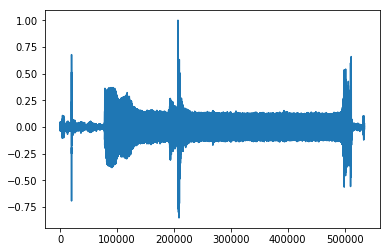

In [3]:
# Read the audio and convert it to floats between 0 and 1.
unpacker = lambda b: numpy.array(struct.unpack('<%dh' % (len(b) // 2,), b)) / 32767
with wave.open('ekg iphone recording.wav', 'rb') as handle:
    assert(handle.getnchannels() == 1)
    assert(handle.getsampwidth() == 2)
    samples = unpacker(handle.readframes(handle.getnframes()))

# Set some variables we'll use later.
CENTRE_FREQ = 19000
SAMPLE_FREQ = 44100

plt.plot(samples)

In [4]:
# A helper function to plot a small portion of the sample.
def plot_centre_ms(values, ms=10):
    middle = len(values) // 2
    one_ms = SAMPLE_FREQ // 1000
    plt.plot(values[middle : middle + (one_ms * ms)])
    

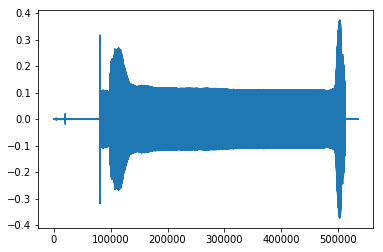

In [5]:
# Kardia outputs an FM signal at 19KHz +/- 1KHz, so create a bandpass filter which
# attenuates frequencies outside this range.

def get_butter_bandpass(lowcut, highcut, fs, order=6):
    # from https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    return b, a

bp_filter_coeffs = get_butter_bandpass(CENTRE_FREQ - 1000, CENTRE_FREQ + 1000, SAMPLE_FREQ)
bandpassed_samples = scipy.signal.lfilter(*bp_filter_coeffs, samples)
plt.plot(bandpassed_samples)

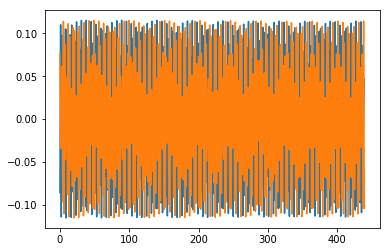

In [6]:
# Begin to demodulate the signal. The basic idea is to find the change in frequency over time.
# We can do this by finding the instantaneous frequency at each sample point, then calculating
# the derivative.

# Start by creating an analytic signal. The analytic signal of a real-valued signal consists
# of a complex-valued signal with the original signal in the real part and a 90-degree phase
# shifted signal in the imaginary part. Having the signal in analytic form makes it easy to
# calculate instantaneous amplitude and frequency in the next cell.
# Useful resources:
# http://blog.robertelder.org/fourier-coefficients-audio-signals/
# https://www.dsprelated.com/freebooks/sasp/Hilbert_Transform_Design_Example.html
# https://dsp.stackexchange.com/questions/44710/hilbert-transform-of-an-fm-signal
analytic = scipy.signal.hilbert(bandpassed_samples)

# Overlaying the two signals shows that they are the same apart from the 90 degree phase shift.
plot_centre_ms(numpy.imag(analytic), 10)
plot_centre_ms(numpy.real(analytic), 10)

# Shift the frequency so that 19KHz is 0KHz.
multiplier = numpy.exp(- (-0+1j * 2 * numpy.pi * CENTRE_FREQ * numpy.arange(bandpassed_samples.shape[0])) / SAMPLE_FREQ)
downshifted_analytic = analytic * multiplier



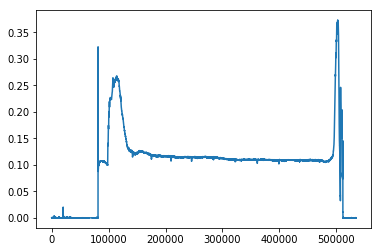

In [7]:
# We can convert the analytic signal to polar co-ordinates consisting of magnitude and
# angle. See
# https://en.wikipedia.org/wiki/Analytic_signal#Envelope_and_instantaneous_phase and
# https://en.wikipedia.org/wiki/Complex_number#Polar_form and
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html
# Find the magnitude, which will give us instantaneous amplitude:
amplitude_envelope = numpy.abs(downshifted_analytic)

plt.plot(amplitude_envelope)

# Find the phase, which will give us instantaneous frequency.
phase = numpy.angle(downshifted_analytic)

# Discard low-amplitude components.
phase[amplitude_envelope < 0.05] = 0

# Typically the start and end of the recording will have recognisably silent portions
phase = numpy.trim_zeros(phase)

# numpy.angle returns angles in "wrapped" form which means there may be discontinuities 
# greater than pi between adjacent angles. numpy.unwrap corrects these to produce a continous
# value.
phase = numpy.unwrap(phase)

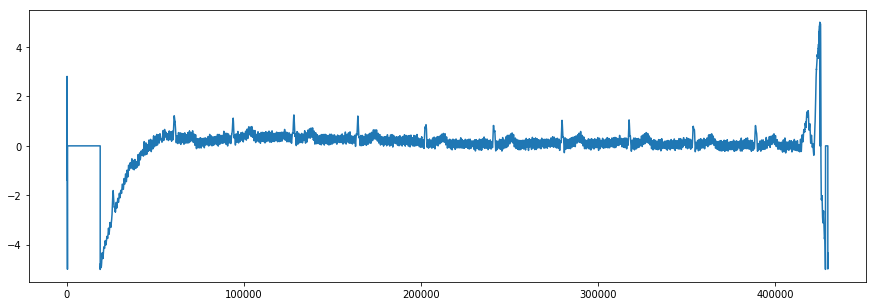

In [8]:
# Given the phase, the instantaneous frequency is simply the first derivative.
instantaneous_frequency = numpy.diff(phase) / ( 2 * numpy.pi * 1 / SAMPLE_FREQ)

# The Kardia device encodes at 1 mV per 200 Hz, so divide by 200 to get mV.
mV = instantaneous_frequency / 200

# The Kardia can't encode voltages higher than 5 mV or lower than -5 mV.
# These occur right at the start and end of recording. 
mV[mV > 5] = 0
mV[mV < -5] = 0

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(mV)

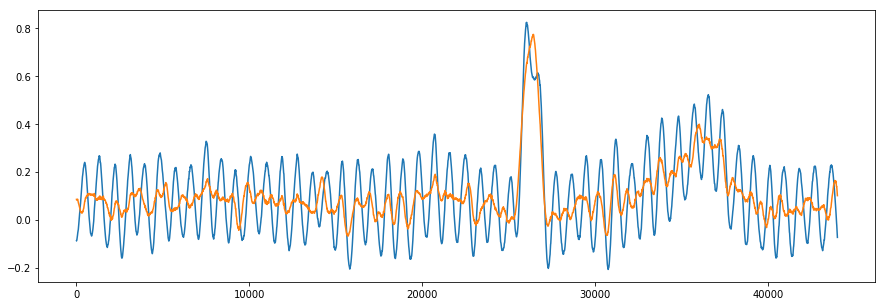

In [9]:
# The signal is starting to become recognisable, but it is very noisy. Part of that noise is due
# to mains hum. Filter it out with a notch filter, which removes specific frequencies but leaves
# others intact. See https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirnotch.html
# Note that this filters 50Hz hum. If you live in a country which has 60Hz mains, change the
# value below.
w0 = 50 / (SAMPLE_FREQ / 2)
quality_factor = 30.0

b, a = scipy.signal.iirnotch(w0, quality_factor)
mV_nomains_notch = scipy.signal.lfilter(b, a, mV)

# This still isn't very good, as we can see in the plot below: mains hum is still having a noticeable
# impact on the signal, and the filter has also attenuated the R points of the signal, which is suboptimal.
# The strategy which comes up a lot is a low-pass filter, but that won't work for EKG signals, parts of which
# are at the same frequency as the mains.

mV_nomains = mV_nomains_notch

fig, ax = plt.subplots(figsize=(15,5))
plot_centre_ms(mV, 1000)
plot_centre_ms(mV_nomains, 1000)


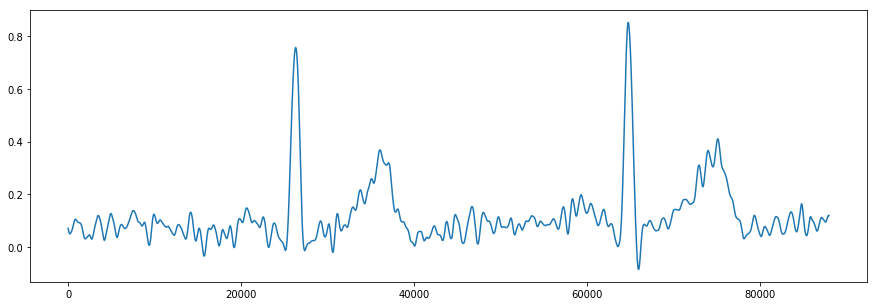

In [11]:
## The signal is still rather noisy, so apply smoothing.

sample_length = SAMPLE_FREQ // 300
one_ms_length = SAMPLE_FREQ // 1000

if False:
    # First attempt:
    # Use a moving average filter to smooth the signal.
    # see https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html

    averaging_signal = numpy.r_[mV_nomains[sample_length-1:0:-1], mV_nomains, mV_nomains[-2:-sample_length-1:-1]]
    filt = numpy.ones(sample_length, 'd')

    mV_filtered = numpy.convolve(filt / filt.sum(), averaging_signal)

# Second attempt: apply a Savitzky-Golay smoothing filter, which tries to fit an
# order-3 curve (in this case) to each window.
savgol_filter_width = one_ms_length * 25 | 1  # filter width must be odd
mV_filtered = scipy.signal.savgol_filter(mV_nomains, savgol_filter_width, 3)

fig, ax = plt.subplots(figsize=(15,5))
#ax.plot(mV_filtered)
plot_centre_ms(mV_filtered, 2000)